# Do some temporal processing for a single MGRS Square

In [2]:
import fsspec
import geopandas as gpd
import pandas as pd
import odc
from odc.geo.geobox import GeoBox
import odc.stac
import pystac_client
import planetary_computer
import numpy as np
from pyproj import Transformer
import hvplot.xarray
import ast
import holoviews as hv
import xarray as xr

## Search for Data

In [3]:
MGRS_TILE = "10UEV"

url = 'https://github.com/scottyhq/mgrs/raw/main/MGRS_LAND.parquet'
with fsspec.open(url) as file:
    gf = gpd.read_parquet(file)
    
aoi = gf.query(' tile == @MGRS_TILE ') # returns a geodataframe
aoi

,tile,geometry,epsg,utm_wkt,utm_bounds
677,10UEV,"POLYGON ((-123.00028 49.65272, -121.47940 49.6...",32610,"POLYGON ((499980 5500020,499980 5390220,609780...","(499980.0, 5390220.0, 609780.0, 5500020.0)"


In [4]:
s = aoi.iloc[0] #geoseries

GEOMETRY = s.geometry.__geo_interface__
BOUNDS = ast.literal_eval(s.utm_bounds)
EPSG = str(s.epsg)

In [5]:
stac_client = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                                        modifier = planetary_computer.sign_inplace,
                                       )

In [6]:
%%time

search = stac_client.search(
    collections = ['sentinel-1-rtc'],
    intersects = GEOMETRY,
    query={"proj:epsg": {"eq": EPSG}}, # Prevent adjacent MGRS Squares
    sortby='+datetime', #ascending order +, descending order -
)

items = search.get_all_items() #1566
print(f'Returned {len(items)} items')

Returned 1644 items
CPU times: user 740 ms, sys: 17 ms, total: 757 ms
Wall time: 7.88 s


In [7]:
# Might have to worry about duplicates in some cases, ignore for now!
# https://github.com/microsoft/PlanetaryComputer/issues/163
# Also manually double check temporal sort:
# https://github.com/microsoft/PlanetaryComputer/issues/164

In [8]:
gf = gpd.GeoDataFrame.from_features( items.to_dict(), crs='EPSG:4326')
gf['stac_id'] = [item.id for item in items]
gf['time'] = pd.to_datetime(gf.datetime) # Use standard xarray dimension name 'time' for index
gf.head()

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator,stac_id,time
0,"POLYGON ((-118.82827 48.34337, -122.24223 48.6...",2014-10-13T14:12:37.269114Z,SENTINEL-1A,"[27606, 20297]","[555770.0, 5362880.0, 830215.0, 5557780.0]",32610,"[20297, 27606]",2014-10-13 14:12:49.768915+00:00,Sentinel-1,high,...,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141013T141224_20141013T1412...,2014-10-13 14:12:37.269114+00:00
1,"POLYGON ((-119.24767 46.87201, -119.27842 46.7...",2014-10-13T14:13:02.269466Z,SENTINEL-1A,"[27783, 20407]","[531710.0, 5186970.0, 807865.0, 5390770.0]",32610,"[20407, 27783]",2014-10-13 14:13:14.768519+00:00,Sentinel-1,high,...,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141013T141249_20141013T1413...,2014-10-13 14:13:02.269466+00:00
2,"POLYGON ((-122.22336 50.74036, -122.66541 49.2...",2014-10-23T14:28:48.224631Z,SENTINEL-1A,"[28067, 21446]","[274920.0, 5458650.0, 554800.0, 5672580.0]",32610,"[21446, 28067]",2014-10-23 14:29:00.723986+00:00,Sentinel-1,high,...,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141023T142835_20141023T1429...,2014-10-23 14:28:48.224631+00:00
3,"POLYGON ((-123.14873 47.78837, -122.66995 49.2...",2014-10-23T14:29:13.224833Z,SENTINEL-1A,"[28393, 21439]","[241800.0, 5292790.0, 524005.0, 5507030.0]",32610,"[21439, 28393]",2014-10-23 14:29:25.724187+00:00,Sentinel-1,high,...,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141023T142900_20141023T1429...,2014-10-23 14:29:13.224833+00:00
4,"POLYGON ((-122.86647 49.23735, -122.41367 47.7...",2014-11-03T01:54:00.431697Z,SENTINEL-1A,"[28739, 21719]","[509720.0, 5287790.0, 795260.0, 5504670.0]",32610,"[21719, 28739]",2014-11-03 01:54:12.931152+00:00,Sentinel-1,high,...,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141103T015347_20141103T0154...,2014-11-03 01:54:00.431697+00:00


In [9]:
# Check no duplicates
with gpd.pd.option_context('display.max_colwidth', None):
    display(gf[gf.stac_id.duplicated()]['stac_id'])

Series([], Name: stac_id, dtype: object)

In [10]:
gf.datetime.is_monotonic

False

In [11]:
# Drop timezone info (always UTC)
gf = gf.set_index('time').tz_localize(None).sort_index()
gf.head()

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator,stac_id
time,,,,,,,,,,,,,,,,,,,,,
2014-10-13 14:12:37.269114,"POLYGON ((-118.82827 48.34337, -122.24223 48.6...",2014-10-13T14:12:37.269114Z,SENTINEL-1A,"[27606, 20297]","[555770.0, 5362880.0, 830215.0, 5557780.0]",32610,"[20297, 27606]",2014-10-13 14:12:49.768915+00:00,Sentinel-1,high,...,20,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141013T141224_20141013T1412...
2014-10-13 14:13:02.269466,"POLYGON ((-119.24767 46.87201, -119.27842 46.7...",2014-10-13T14:13:02.269466Z,SENTINEL-1A,"[27783, 20407]","[531710.0, 5186970.0, 807865.0, 5390770.0]",32610,"[20407, 27783]",2014-10-13 14:13:14.768519+00:00,Sentinel-1,high,...,20,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141013T141249_20141013T1413...
2014-10-23 14:28:48.224631,"POLYGON ((-122.22336 50.74036, -122.66541 49.2...",2014-10-23T14:28:48.224631Z,SENTINEL-1A,"[28067, 21446]","[274920.0, 5458650.0, 554800.0, 5672580.0]",32610,"[21446, 28067]",2014-10-23 14:29:00.723986+00:00,Sentinel-1,high,...,20,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141023T142835_20141023T1429...
2014-10-23 14:29:13.224833,"POLYGON ((-123.14873 47.78837, -122.66995 49.2...",2014-10-23T14:29:13.224833Z,SENTINEL-1A,"[28393, 21439]","[241800.0, 5292790.0, 524005.0, 5507030.0]",32610,"[21439, 28393]",2014-10-23 14:29:25.724187+00:00,Sentinel-1,high,...,20,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141023T142900_20141023T1429...
2014-11-03 01:54:00.431697,"POLYGON ((-122.86647 49.23735, -122.41367 47.7...",2014-11-03T01:54:00.431697Z,SENTINEL-1A,"[28739, 21719]","[509720.0, 5287790.0, 795260.0, 5504670.0]",32610,"[21719, 28739]",2014-11-03 01:54:12.931152+00:00,Sentinel-1,high,...,20,Fast-24h,22,10,right,10,4.4,3,0000-000A,S1A_IW_GRDH_1SSV_20141103T015347_20141103T0154...


In [12]:
gf.index.is_monotonic

True

In [13]:
# Some acquisitions do not have HV:
gf[gf['sar:polarizations'].apply(lambda x: x == ['VV'])]['sat:relative_orbit'].value_counts()

115    76
86     62
13     40
64     39
137    35
Name: sat:relative_orbit, dtype: int64

## Load Xarray 

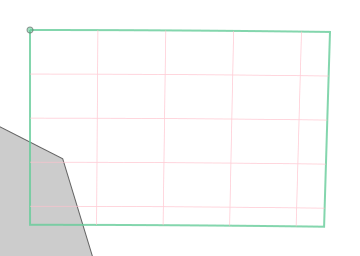

In [14]:
# Full resolution Data
GRID = GeoBox.from_bbox(BOUNDS, 
                 crs=EPSG,
                 #resolution=10,
                 #resolution=20,
                 #resolution=100,
                 resolution=500,       
                 #resolution=1000,
                )
GRID

In [15]:
s1 = odc.stac.load(
    items,
    #groupby="solar_day", #cool automagically merges frames since they are on the same day! for frame overlap probably just takes one rather than ave
    chunks={'x': 512, 'y': 512}, #IF not set will actually read the pixels in eagerly!
    bands="vv",
    geobox=GRID
)

s1 

<xarray.Dataset>
Dimensions:      (y: 221, x: 221, time: 1644)
Coordinates:
  * y            (y) float64 5.5e+06 5.5e+06 5.499e+06 ... 5.391e+06 5.39e+06
  * x            (x) float64 4.998e+05 5.002e+05 ... 6.092e+05 6.098e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2014-10-13T14:12:37.269114 ... 2023-01...
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 221, 221), meta=np.ndarray>

In [16]:
# Check for monotonic increasing times.
np.all(np.diff(s1.time.values).astype(int) > 0)

True

In [17]:
s1

<xarray.Dataset>
Dimensions:      (y: 221, x: 221, time: 1644)
Coordinates:
  * y            (y) float64 5.5e+06 5.5e+06 5.499e+06 ... 5.391e+06 5.39e+06
  * x            (x) float64 4.998e+05 5.002e+05 ... 6.092e+05 6.098e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2014-10-13T14:12:37.269114 ... 2023-01...
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 221, 221), meta=np.ndarray>

In [18]:
#
# Add non-dimensional coordinates from select STAC metadata
#This works b/c pandas series labeled with 'time' and same timestamps!
s1 = s1.assign_coords(relative_orbit=gf['sat:relative_orbit'],
                      orbit_state=gf['sat:orbit_state'],
                      stac_id=gf['stac_id'],
                     )
                 
s1

<xarray.Dataset>
Dimensions:         (y: 221, x: 221, time: 1644)
Coordinates:
  * y               (y) float64 5.5e+06 5.5e+06 5.499e+06 ... 5.391e+06 5.39e+06
  * x               (x) float64 4.998e+05 5.002e+05 ... 6.092e+05 6.098e+05
    spatial_ref     int32 32610
  * time            (time) datetime64[ns] 2014-10-13T14:12:37.269114 ... 2023...
    relative_orbit  (time) int64 115 115 86 86 64 64 ... 137 13 64 64 115 115
    orbit_state     (time) object 'descending' 'descending' ... 'descending'
    stac_id         (time) object 'S1A_IW_GRDH_1SSV_20141013T141224_20141013T...
Data variables:
    vv              (time, y, x) float32 dask.array<chunksize=(1, 221, 221), meta=np.ndarray>

In [20]:
transformer = Transformer.from_crs(4326, EPSG, always_xy=True)
lon,lat = (-121.822815, 48.756829)
easting,northing = transformer.transform(lon,lat)
easting, northing

(586519.8737521493, 5401092.543264157)

In [21]:
%%time
# Do some Dask
# Consider getting timeseries for specific point, this will require opening 1568 different COG files in object storage, so I'd estimate
#200e-3 * 1568 / 60 # 5 minutes in serial. We have 4 cores so maybe 1 min?


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 19.1 µs


In [22]:
from dask.distributed import Client, LocalCluster

In [23]:
cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37611 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/scottyh@uw.edu/proxy/37611/status,
Dashboard: /user/scottyh@uw.edu/proxy/37611/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: False
Comm: inproc://10.244.52.8/1846/1,Workers: 4
Dashboard: /user/scottyh@uw.edu/proxy/37611/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: inproc://10.244.52.8/1846/4,Total threads: 1
Dashboard: /user/scottyh@uw.edu/proxy/46333/status,Memory: 8.00 GiB
Nanny: None,


In [24]:
%%time
# NOTE: for largest overview it should take about the same amount of time as pulling a single pixel
# b/c GDAL pulls in entire block of pixel values...

# NOTE: timeseries will likely take on different forms for different amounts of spatial averaging!

#ts = s1.vv.isel(y=5000, x=2000).compute()
ts = s1.vv.sel(x=easting, y=northing, method='nearest').compute() #Why is rasterio.warp used here?

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 1min 23s, sys: 1min 15s, total: 2min 38s
Wall time: 1min 22s


In [25]:
ts = ts.where(ts!=s1.vv.attrs['nodata'])

In [26]:
# NOTE lots of nans
ts.hvplot.scatter(x='time')

:Scatter   [time]   (vv)

In [27]:
ts.hvplot.scatter(x='time', by=['relative_orbit', 'orbit_state'] )

:NdOverlay   [relative_orbit,orbit_state]
   :Scatter   [time]   (vv)

In [28]:
# NOTE: relorb 86 does not cover this point!
scatter = ts[ts['relative_orbit'] == 137].hvplot.scatter(x='time')
#mean_trend = ts.mean(dim='time').hvplot.line(title='North Grand Mesa', color='red')
scatter

:Scatter   [time]   (vv)

In [29]:
# Plot running median
test = ts[ts['relative_orbit'] == 115]
scatter = test.hvplot.scatter(x='time')
scatter

:Scatter   [time]   (vv)

In [30]:
# NOTES: 
#'24D' captures later minima
#'48' seems good to capture earlier onset minimum, but need to consider other locations...
# 12D overfits! 
period = '48D'
mean_24day = test.resample(time=period, skipna=True).median().dropna(dim='time')
line = mean_24day.hvplot.line(c='red')
scatter * line

:Overlay
   .Scatter.I :Scatter   [time]   (vv)
   .Curve.I   :Curve   [time]   (vv)

In [33]:
ts.sel(time='2018').idxmin()

<xarray.DataArray 'time' ()>
array('2018-05-19T14:12:27.760953000', dtype='datetime64[ns]')
Coordinates:
    y               float64 5.401e+06
    x               float64 5.868e+05
    spatial_ref     int32 32610
    relative_orbit  int64 115
    orbit_state     object 'descending'
    stac_id         object 'S1B_IW_GRDH_1SDV_20180519T141215_20180519T141240_...

In [34]:
test = ts.groupby('time.year').apply(lambda x: x.idxmin())
test

<xarray.DataArray 'time' (year: 10)>
array(['2014-11-06T14:12:37.115109000', '2015-05-26T01:53:59.102529000',
       '2016-06-04T14:13:04.131526000', '2017-05-26T02:01:31.665149000',
       '2018-05-19T14:12:27.760953000', '2019-05-26T14:12:34.617086000',
       '2020-06-15T02:02:00.514401000', '2021-05-29T02:02:05.279180000',
       '2022-06-21T14:13:44.031353000', '2023-01-01T02:02:49.071500000'],
      dtype='datetime64[ns]')
Coordinates:
    y               float64 5.401e+06
    x               float64 5.868e+05
    spatial_ref     int32 32610
    relative_orbit  (year) int64 115 64 115 137 115 115 137 137 115 137
    orbit_state     (year) object 'descending' 'ascending' ... 'ascending'
    stac_id         (year) object 'S1A_IW_GRDH_1SSV_20141106T141224_20141106T...
  * year            (year) int64 2014 2015 2016 2017 ... 2020 2021 2022 2023

In [35]:
list_of_lines = [hv.VLine(x).opts(line_color='k',line_width=0.5) for x in test.values]
scatter * line * hv.Overlay(list_of_lines)

:Overlay
   .Scatter.I  :Scatter   [time]   (vv)
   .Curve.I    :Curve   [time]   (vv)
   .VLine.I    :VLine   [x,y]
   .VLine.II   :VLine   [x,y]
   .VLine.III  :VLine   [x,y]
   .VLine.IV   :VLine   [x,y]
   .VLine.V    :VLine   [x,y]
   .VLine.VI   :VLine   [x,y]
   .VLine.VII  :VLine   [x,y]
   .VLine.VIII :VLine   [x,y]
   .VLine.IX   :VLine   [x,y]
   .VLine.X    :VLine   [x,y]

In [36]:
# Convert times to simple dayofyear
points = test.sel(year=slice('2015','2022')).dt.dayofyear.hvplot.scatter()

In [38]:
b = test.sel(year=slice('2015','2022')).dt.dayofyear
fit = b.polyfit(dim='year', deg=1)
fit

<xarray.Dataset>
Dimensions:               (degree: 2)
Coordinates:
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree) float64 2.583 -5.062e+03

In [39]:
fit_vals = xr.polyval(coord=b.year, coeffs=fit.polyfit_coefficients)
fit_vals.name = 'melt onset day.of.year'

In [40]:
print(f'Melt onset rate of change since 2015:  {float(fit.polyfit_coefficients[0]):.2f} days/year')

Melt onset rate of change since 2015:  2.58 days/year


In [41]:
trend = fit_vals.hvplot.line(x='year', color='r')
trend * points

:Overlay
   .Curve.I   :Curve   [year]   (melt onset day.of.year)
   .Scatter.I :Scatter   [year]   (dayofyear)